Package imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

Explore directory to figure out what is where

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon-images-and-types/pokemon.csv
/kaggle/input/pokemon-images-and-types/images/images/luxio.png
/kaggle/input/pokemon-images-and-types/images/images/oshawott.png
/kaggle/input/pokemon-images-and-types/images/images/parasect.png
/kaggle/input/pokemon-images-and-types/images/images/taillow.png
/kaggle/input/pokemon-images-and-types/images/images/porygon.png
/kaggle/input/pokemon-images-and-types/images/images/feraligatr.png
/kaggle/input/pokemon-images-and-types/images/images/eelektross.png
/kaggle/input/pokemon-images-and-types/images/images/scyther.png
/kaggle/input/pokemon-images-and-types/images/images/magmar.png
/kaggle/input/pokemon-images-and-types/images/images/swalot.png
/kaggle/input/pokemon-images-and-types/images/images/magneton.png
/kaggle/input/pokemon-images-and-types/images/images/skitty.png
/kaggle/input/pokemon-images-and-types/images/images/stunfisk.png
/kaggle/input/pokemon-images-and-types/images/images/clawitzer.png
/kaggle/input/pokemon-images-and

Load the info data frame and look around

In [11]:
manifest=pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')

In [12]:
manifest.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [13]:
manifest.describe()

,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,azurill,Water,Flying
freq,1,114,95


Confirm that type 2 is only column with NaNs

In [14]:
np.any(manifest.Name.isna()),np.any(manifest.Type1.isna()),np.any(manifest.Type2.isna())

(False, False, True)

Add a class for missing values

In [15]:
manifest.Type2[manifest.Type2.isna()] = "No Second Type"

One-hot encode *y*s

In [16]:
y1=pd.get_dummies(manifest.Type1)

In [17]:
y2=pd.get_dummies(manifest.Type2)

In [18]:
y1.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
y2

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,No Second Type,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
805,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
806,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
807,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


I just rearranged the columns here, but turns out it might not have been necessary

In [20]:
fixcols=y2.columns.tolist()[0:12]
for i in y2.columns.tolist()[13:19]:
    fixcols.append(i)
fixcols.append(y2.columns.tolist()[12])
y2=y2[fixcols]

Add a column for 'No second type' class to first class, to allow combining the two sets

In [21]:
y1['No Second Type']=0

In [22]:
y1.values.shape,y2.values.shape
y2+y1

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
805,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
806,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


Concatenate the pokemon names with their one-hot encoded types

In [23]:
manifest=pd.concat([manifest['Name'].reset_index(drop=True), y2+y1], axis=1)

In [24]:
manifest

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
0,bulbasaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,ivysaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,venusaur,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,charmander,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,charmeleon,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
805,blacephalon,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
806,zeraora,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
807,meltan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


Look at an example image and find out array dimensions

<class 'PIL.Image.Image'>
float32
(120, 120, 3)


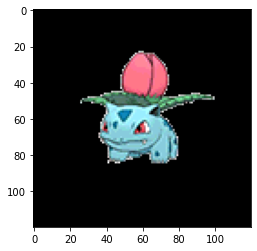

In [25]:
# load an example image
img = load_img('/kaggle/input/pokemon-images-and-types/images/images/ivysaur.png')
print(type(img))
# convert to numpy array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
#show image
plt.imshow(img);

Check pixel value range

In [26]:
np.max(img_array)

255.0

Obtain and normalise x values between (0,1)

In [27]:
names=[]
index=0

for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images/images/'):
    for filename in filenames:
        file_path_i = os.path.join(dirname, filename)
        name_i = filename.replace('.png','')
        names.append({'Name':name_i,'ix':index})
        if index==0:
            x=load_img(file_path_i)
            x=img_to_array(x)
            x.shape=(1,120,120,3)
            x=x/255.
        else:
            xi=load_img(file_path_i)
            xi=img_to_array(xi)
            xi.shape=(1,120,120,3)
            xi=xi/255.
            x = np.concatenate((x,xi),axis=0)
        index+=1
        #print(index)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [28]:
names=pd.DataFrame(names)

In [29]:
names.head()

,Name,ix
0,luxio,0
1,oshawott,1
2,parasect,2
3,taillow,3
4,porygon,4


Here I was just figuring out why merging on Name resulted in dropped values, turns out there are some images for which there is no data in the manifest, so ended up dropping those

In [30]:
len(names.Name.unique()),len(manifest.Name.unique()),len(names.ix.unique())

(809, 809, 809)

In [31]:
manifest=manifest.merge(names,how='left')

In [32]:
np.where(manifest.ix.isna())

(array([721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733,
        734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746,
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759,
        760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
        773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785,
        786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,
        799, 800, 801, 802, 803, 804, 805, 806, 807, 808]),)

In [33]:
len(os.listdir('/kaggle/input/pokemon-images-and-types/images/images/'))

809

In [34]:
missing=[]
for i in manifest[manifest.ix.isna()].Name.values:
    missing.append(i in names.Name)
np.any(missing)

False

In [35]:
dropme=np.where(manifest.ix.isna())

In [36]:
dropme

(array([721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733,
        734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746,
        747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759,
        760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
        773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785,
        786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,
        799, 800, 801, 802, 803, 804, 805, 806, 807, 808]),)

In [37]:
manifest.dropna(inplace=True)

In [38]:
manifest = manifest.set_index('ix',drop=True).sort_index()

In [39]:
manifest

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
ix,,,,,,,,,,,,,,,,,,,,
0.0,luxio,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1.0,oshawott,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2.0,parasect,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3.0,taillow,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4.0,porygon,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804.0,slaking,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
805.0,psyduck,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
806.0,galvantula,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
np.delete(x,dropme,axis=0).shape

(721, 120, 120, 3)

In [41]:
x= np.delete(x,dropme,axis=0)

In [42]:
manifest.drop('Name',axis=1).values.shape

(721, 19)

In [43]:
y=manifest.drop('Name',axis=1).values

In [44]:
type(y),type(x)

(numpy.ndarray, numpy.ndarray)

In [45]:
x = np.float32(x)

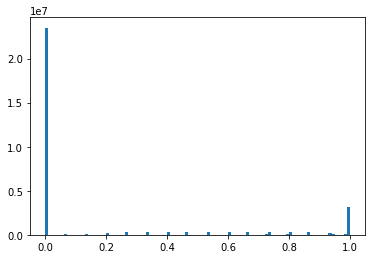

In [46]:
plt.hist(x.ravel(),bins=100);

# Note: my first goal was to classify both the first and second class simultaneously, later in the notebook I focussed only on classifying the first class

**First model**

Here, I decided to give more range to the final layer's output by scaling y to (-1,1) and using a Tanh output activation function instead

In [47]:
new_y = np.where(y==0, -1, y)

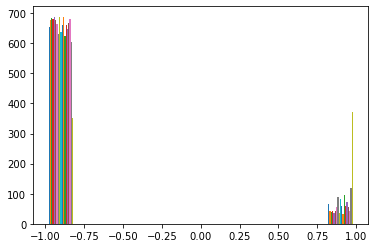

In [48]:
plt.hist(new_y);

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
     x, new_y, test_size=0.1, random_state=42)

Build and compile final model with MSE loss and tanh activation in final layer, very deep model (with perhaps too much?) dropout

In [50]:
model = Sequential()
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='tanh',input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='tanh'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1024,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(512,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(256,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(128,activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(64,activation='tanh'))
model.add(Dense(y.shape[1],activation='tanh'))

adam=tf.keras.optimizers.Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)

model.compile(optimizer=adam,
              loss="mse",
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(X_train,y_train,batch_size=128,epochs=2000,validation_split=0.1,shuffle=True)

Epoch 1/2000
5/5 [==============================] - 1s 195ms/step - loss: 1.0884 - mean_absolute_error: 1.0080 - val_loss: 1.0137 - val_mean_absolute_error: 1.0021
Epoch 2/2000
5/5 [==============================] - 0s 67ms/step - loss: 1.0845 - mean_absolute_error: 1.0062 - val_loss: 1.0109 - val_mean_absolute_error: 1.0008
Epoch 3/2000
5/5 [==============================] - 0s 66ms/step - loss: 1.0747 - mean_absolute_error: 1.0020 - val_loss: 1.0083 - val_mean_absolute_error: 0.9995
Epoch 4/2000
5/5 [==============================] - 0s 64ms/step - loss: 1.0701 - mean_absolute_error: 0.9996 - val_loss: 1.0056 - val_mean_absolute_error: 0.9983
Epoch 5/2000
5/5 [==============================] - 0s 65ms/step - loss: 1.0660 - mean_absolute_error: 0.9984 - val_loss: 1.0030 - val_mean_absolute_error: 0.9970
Epoch 6/2000
5/5 [==============================] - 0s 83ms/step - loss: 1.0633 - mean_absolute_error: 0.9964 - val_loss: 1.0004 - val_mean_absolute_error: 0.9958
Epoch 7/2000
5/5 [===

5/5 [==============================] - 0s 64ms/step - loss: 0.8864 - mean_absolute_error: 0.9024 - val_loss: 0.8929 - val_mean_absolute_error: 0.9390
Epoch 52/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.8851 - mean_absolute_error: 0.9013 - val_loss: 0.8902 - val_mean_absolute_error: 0.9375
Epoch 53/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.8750 - mean_absolute_error: 0.8952 - val_loss: 0.8876 - val_mean_absolute_error: 0.9360
Epoch 54/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.8716 - mean_absolute_error: 0.8932 - val_loss: 0.8850 - val_mean_absolute_error: 0.9345
Epoch 55/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.8680 - mean_absolute_error: 0.8911 - val_loss: 0.8823 - val_mean_absolute_error: 0.9329
Epoch 56/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.8646 - mean_absolute_error: 0.8891 - val_loss: 0.8796 - val_mean_absolute_error: 0.9313
Epoch 57/2000
5/5 [===========

5/5 [==============================] - 0s 66ms/step - loss: 0.7327 - mean_absolute_error: 0.7939 - val_loss: 0.7458 - val_mean_absolute_error: 0.8466
Epoch 102/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.7297 - mean_absolute_error: 0.7904 - val_loss: 0.7427 - val_mean_absolute_error: 0.8445
Epoch 103/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.7249 - mean_absolute_error: 0.7886 - val_loss: 0.7396 - val_mean_absolute_error: 0.8423
Epoch 104/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.7223 - mean_absolute_error: 0.7866 - val_loss: 0.7365 - val_mean_absolute_error: 0.8402
Epoch 105/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.7188 - mean_absolute_error: 0.7830 - val_loss: 0.7335 - val_mean_absolute_error: 0.8380
Epoch 106/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.7216 - mean_absolute_error: 0.7861 - val_loss: 0.7304 - val_mean_absolute_error: 0.8359
Epoch 107/2000
5/5 [=====

Epoch 151/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.6146 - mean_absolute_error: 0.6956 - val_loss: 0.6025 - val_mean_absolute_error: 0.7381
Epoch 152/2000
5/5 [==============================] - 0s 74ms/step - loss: 0.6124 - mean_absolute_error: 0.6949 - val_loss: 0.6001 - val_mean_absolute_error: 0.7361
Epoch 153/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.6120 - mean_absolute_error: 0.6945 - val_loss: 0.5976 - val_mean_absolute_error: 0.7340
Epoch 154/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6131 - mean_absolute_error: 0.6957 - val_loss: 0.5952 - val_mean_absolute_error: 0.7319
Epoch 155/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6074 - mean_absolute_error: 0.6906 - val_loss: 0.5928 - val_mean_absolute_error: 0.7298
Epoch 156/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.6158 - mean_absolute_error: 0.6945 - val_loss: 0.5904 - val_mean_absolute_error: 0.7278
Epoch 157/

Epoch 201/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.5423 - mean_absolute_error: 0.6292 - val_loss: 0.5020 - val_mean_absolute_error: 0.6442
Epoch 202/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.5369 - mean_absolute_error: 0.6231 - val_loss: 0.5004 - val_mean_absolute_error: 0.6426
Epoch 203/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.5448 - mean_absolute_error: 0.6275 - val_loss: 0.4989 - val_mean_absolute_error: 0.6409
Epoch 204/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.5430 - mean_absolute_error: 0.6275 - val_loss: 0.4973 - val_mean_absolute_error: 0.6393
Epoch 205/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.5430 - mean_absolute_error: 0.6282 - val_loss: 0.4958 - val_mean_absolute_error: 0.6377
Epoch 206/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.5388 - mean_absolute_error: 0.6243 - val_loss: 0.4943 - val_mean_absolute_error: 0.6360
Epoch 207/

Epoch 251/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4949 - mean_absolute_error: 0.5766 - val_loss: 0.4408 - val_mean_absolute_error: 0.5725
Epoch 252/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4941 - mean_absolute_error: 0.5779 - val_loss: 0.4399 - val_mean_absolute_error: 0.5712
Epoch 253/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4976 - mean_absolute_error: 0.5774 - val_loss: 0.4390 - val_mean_absolute_error: 0.5700
Epoch 254/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4986 - mean_absolute_error: 0.5771 - val_loss: 0.4381 - val_mean_absolute_error: 0.5688
Epoch 255/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4908 - mean_absolute_error: 0.5740 - val_loss: 0.4372 - val_mean_absolute_error: 0.5676
Epoch 256/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4939 - mean_absolute_error: 0.5752 - val_loss: 0.4363 - val_mean_absolute_error: 0.5664
Epoch 257/

Epoch 301/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4592 - mean_absolute_error: 0.5385 - val_loss: 0.4047 - val_mean_absolute_error: 0.5197
Epoch 302/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.4668 - mean_absolute_error: 0.5421 - val_loss: 0.4042 - val_mean_absolute_error: 0.5188
Epoch 303/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.4613 - mean_absolute_error: 0.5398 - val_loss: 0.4037 - val_mean_absolute_error: 0.5179
Epoch 304/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.4605 - mean_absolute_error: 0.5386 - val_loss: 0.4031 - val_mean_absolute_error: 0.5170
Epoch 305/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4618 - mean_absolute_error: 0.5384 - val_loss: 0.4026 - val_mean_absolute_error: 0.5161
Epoch 306/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4594 - mean_absolute_error: 0.5339 - val_loss: 0.4021 - val_mean_absolute_error: 0.5152
Epoch 307/

Epoch 351/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4431 - mean_absolute_error: 0.5127 - val_loss: 0.3831 - val_mean_absolute_error: 0.4808
Epoch 352/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4418 - mean_absolute_error: 0.5130 - val_loss: 0.3828 - val_mean_absolute_error: 0.4802
Epoch 353/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4429 - mean_absolute_error: 0.5120 - val_loss: 0.3824 - val_mean_absolute_error: 0.4795
Epoch 354/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4384 - mean_absolute_error: 0.5110 - val_loss: 0.3821 - val_mean_absolute_error: 0.4788
Epoch 355/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4409 - mean_absolute_error: 0.5117 - val_loss: 0.3818 - val_mean_absolute_error: 0.4781
Epoch 356/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4431 - mean_absolute_error: 0.5129 - val_loss: 0.3815 - val_mean_absolute_error: 0.4775
Epoch 357/

Epoch 401/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4260 - mean_absolute_error: 0.4899 - val_loss: 0.3696 - val_mean_absolute_error: 0.4516
Epoch 402/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4237 - mean_absolute_error: 0.4896 - val_loss: 0.3694 - val_mean_absolute_error: 0.4511
Epoch 403/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.4253 - mean_absolute_error: 0.4880 - val_loss: 0.3692 - val_mean_absolute_error: 0.4507
Epoch 404/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.4246 - mean_absolute_error: 0.4890 - val_loss: 0.3690 - val_mean_absolute_error: 0.4502
Epoch 405/2000
5/5 [==============================] - 0s 75ms/step - loss: 0.4265 - mean_absolute_error: 0.4904 - val_loss: 0.3688 - val_mean_absolute_error: 0.4497
Epoch 406/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.4265 - mean_absolute_error: 0.4886 - val_loss: 0.3686 - val_mean_absolute_error: 0.4492
Epoch 407/

Epoch 451/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4135 - mean_absolute_error: 0.4706 - val_loss: 0.3610 - val_mean_absolute_error: 0.4293
Epoch 452/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4100 - mean_absolute_error: 0.4709 - val_loss: 0.3608 - val_mean_absolute_error: 0.4289
Epoch 453/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.4144 - mean_absolute_error: 0.4728 - val_loss: 0.3607 - val_mean_absolute_error: 0.4285
Epoch 454/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.4115 - mean_absolute_error: 0.4708 - val_loss: 0.3605 - val_mean_absolute_error: 0.4281
Epoch 455/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4130 - mean_absolute_error: 0.4720 - val_loss: 0.3604 - val_mean_absolute_error: 0.4277
Epoch 456/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.4095 - mean_absolute_error: 0.4688 - val_loss: 0.3603 - val_mean_absolute_error: 0.4273
Epoch 457/

Epoch 501/2000
5/5 [==============================] - 0s 63ms/step - loss: 0.4016 - mean_absolute_error: 0.4556 - val_loss: 0.3552 - val_mean_absolute_error: 0.4113
Epoch 502/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.4053 - mean_absolute_error: 0.4568 - val_loss: 0.3551 - val_mean_absolute_error: 0.4110
Epoch 503/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.4041 - mean_absolute_error: 0.4563 - val_loss: 0.3551 - val_mean_absolute_error: 0.4107
Epoch 504/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3998 - mean_absolute_error: 0.4525 - val_loss: 0.3550 - val_mean_absolute_error: 0.4103
Epoch 505/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.4013 - mean_absolute_error: 0.4525 - val_loss: 0.3549 - val_mean_absolute_error: 0.4100
Epoch 506/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3991 - mean_absolute_error: 0.4523 - val_loss: 0.3548 - val_mean_absolute_error: 0.4097
Epoch 507/

Epoch 551/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3993 - mean_absolute_error: 0.4445 - val_loss: 0.3512 - val_mean_absolute_error: 0.3969
Epoch 552/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3955 - mean_absolute_error: 0.4436 - val_loss: 0.3511 - val_mean_absolute_error: 0.3966
Epoch 553/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3971 - mean_absolute_error: 0.4434 - val_loss: 0.3510 - val_mean_absolute_error: 0.3964
Epoch 554/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3895 - mean_absolute_error: 0.4405 - val_loss: 0.3510 - val_mean_absolute_error: 0.3962
Epoch 555/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3957 - mean_absolute_error: 0.4428 - val_loss: 0.3509 - val_mean_absolute_error: 0.3959
Epoch 556/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.3974 - mean_absolute_error: 0.4447 - val_loss: 0.3508 - val_mean_absolute_error: 0.3957
Epoch 557/

Epoch 601/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3912 - mean_absolute_error: 0.4329 - val_loss: 0.3482 - val_mean_absolute_error: 0.3850
Epoch 602/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3902 - mean_absolute_error: 0.4334 - val_loss: 0.3481 - val_mean_absolute_error: 0.3847
Epoch 603/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3855 - mean_absolute_error: 0.4307 - val_loss: 0.3481 - val_mean_absolute_error: 0.3845
Epoch 604/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3937 - mean_absolute_error: 0.4341 - val_loss: 0.3480 - val_mean_absolute_error: 0.3843
Epoch 605/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.3912 - mean_absolute_error: 0.4346 - val_loss: 0.3480 - val_mean_absolute_error: 0.3841
Epoch 606/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3887 - mean_absolute_error: 0.4315 - val_loss: 0.3479 - val_mean_absolute_error: 0.3839
Epoch 607/

Epoch 651/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3789 - mean_absolute_error: 0.4192 - val_loss: 0.3461 - val_mean_absolute_error: 0.3750
Epoch 652/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3806 - mean_absolute_error: 0.4205 - val_loss: 0.3460 - val_mean_absolute_error: 0.3749
Epoch 653/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3808 - mean_absolute_error: 0.4234 - val_loss: 0.3460 - val_mean_absolute_error: 0.3747
Epoch 654/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3844 - mean_absolute_error: 0.4221 - val_loss: 0.3459 - val_mean_absolute_error: 0.3745
Epoch 655/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3854 - mean_absolute_error: 0.4230 - val_loss: 0.3459 - val_mean_absolute_error: 0.3743
Epoch 656/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3819 - mean_absolute_error: 0.4220 - val_loss: 0.3458 - val_mean_absolute_error: 0.3741
Epoch 657/

Epoch 701/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3788 - mean_absolute_error: 0.4127 - val_loss: 0.3446 - val_mean_absolute_error: 0.3664
Epoch 702/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3783 - mean_absolute_error: 0.4133 - val_loss: 0.3446 - val_mean_absolute_error: 0.3663
Epoch 703/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3764 - mean_absolute_error: 0.4132 - val_loss: 0.3446 - val_mean_absolute_error: 0.3661
Epoch 704/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3790 - mean_absolute_error: 0.4134 - val_loss: 0.3445 - val_mean_absolute_error: 0.3660
Epoch 705/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3810 - mean_absolute_error: 0.4145 - val_loss: 0.3445 - val_mean_absolute_error: 0.3658
Epoch 706/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.3807 - mean_absolute_error: 0.4129 - val_loss: 0.3445 - val_mean_absolute_error: 0.3656
Epoch 707/

Epoch 751/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3766 - mean_absolute_error: 0.4076 - val_loss: 0.3432 - val_mean_absolute_error: 0.3594
Epoch 752/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3737 - mean_absolute_error: 0.4042 - val_loss: 0.3431 - val_mean_absolute_error: 0.3593
Epoch 753/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3714 - mean_absolute_error: 0.4030 - val_loss: 0.3431 - val_mean_absolute_error: 0.3591
Epoch 754/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3747 - mean_absolute_error: 0.4060 - val_loss: 0.3431 - val_mean_absolute_error: 0.3590
Epoch 755/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3734 - mean_absolute_error: 0.4050 - val_loss: 0.3431 - val_mean_absolute_error: 0.3589
Epoch 756/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3748 - mean_absolute_error: 0.4064 - val_loss: 0.3430 - val_mean_absolute_error: 0.3587
Epoch 757/

Epoch 801/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3743 - mean_absolute_error: 0.4023 - val_loss: 0.3421 - val_mean_absolute_error: 0.3532
Epoch 802/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3725 - mean_absolute_error: 0.3988 - val_loss: 0.3421 - val_mean_absolute_error: 0.3531
Epoch 803/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3692 - mean_absolute_error: 0.3975 - val_loss: 0.3421 - val_mean_absolute_error: 0.3529
Epoch 804/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3695 - mean_absolute_error: 0.3976 - val_loss: 0.3420 - val_mean_absolute_error: 0.3528
Epoch 805/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3718 - mean_absolute_error: 0.3996 - val_loss: 0.3420 - val_mean_absolute_error: 0.3527
Epoch 806/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3714 - mean_absolute_error: 0.3973 - val_loss: 0.3420 - val_mean_absolute_error: 0.3526
Epoch 807/

Epoch 851/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3689 - mean_absolute_error: 0.3933 - val_loss: 0.3414 - val_mean_absolute_error: 0.3477
Epoch 852/2000
5/5 [==============================] - 0s 73ms/step - loss: 0.3694 - mean_absolute_error: 0.3918 - val_loss: 0.3414 - val_mean_absolute_error: 0.3476
Epoch 853/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3683 - mean_absolute_error: 0.3912 - val_loss: 0.3414 - val_mean_absolute_error: 0.3474
Epoch 854/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3672 - mean_absolute_error: 0.3917 - val_loss: 0.3413 - val_mean_absolute_error: 0.3473
Epoch 855/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3685 - mean_absolute_error: 0.3920 - val_loss: 0.3413 - val_mean_absolute_error: 0.3472
Epoch 856/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3652 - mean_absolute_error: 0.3892 - val_loss: 0.3413 - val_mean_absolute_error: 0.3471
Epoch 857/

Epoch 901/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3663 - mean_absolute_error: 0.3867 - val_loss: 0.3408 - val_mean_absolute_error: 0.3424
Epoch 902/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3685 - mean_absolute_error: 0.3889 - val_loss: 0.3408 - val_mean_absolute_error: 0.3423
Epoch 903/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.3664 - mean_absolute_error: 0.3868 - val_loss: 0.3408 - val_mean_absolute_error: 0.3422
Epoch 904/2000
5/5 [==============================] - 0s 74ms/step - loss: 0.3652 - mean_absolute_error: 0.3860 - val_loss: 0.3408 - val_mean_absolute_error: 0.3421
Epoch 905/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3628 - mean_absolute_error: 0.3847 - val_loss: 0.3407 - val_mean_absolute_error: 0.3421
Epoch 906/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3617 - mean_absolute_error: 0.3833 - val_loss: 0.3407 - val_mean_absolute_error: 0.3420
Epoch 907/

Epoch 951/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3666 - mean_absolute_error: 0.3828 - val_loss: 0.3403 - val_mean_absolute_error: 0.3380
Epoch 952/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3655 - mean_absolute_error: 0.3830 - val_loss: 0.3403 - val_mean_absolute_error: 0.3379
Epoch 953/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3635 - mean_absolute_error: 0.3822 - val_loss: 0.3403 - val_mean_absolute_error: 0.3378
Epoch 954/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3656 - mean_absolute_error: 0.3815 - val_loss: 0.3403 - val_mean_absolute_error: 0.3377
Epoch 955/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3624 - mean_absolute_error: 0.3794 - val_loss: 0.3403 - val_mean_absolute_error: 0.3376
Epoch 956/2000
5/5 [==============================] - 0s 73ms/step - loss: 0.3636 - mean_absolute_error: 0.3812 - val_loss: 0.3402 - val_mean_absolute_error: 0.3376
Epoch 957/

Epoch 1001/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3633 - mean_absolute_error: 0.3765 - val_loss: 0.3398 - val_mean_absolute_error: 0.3340
Epoch 1002/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3614 - mean_absolute_error: 0.3768 - val_loss: 0.3398 - val_mean_absolute_error: 0.3339
Epoch 1003/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3603 - mean_absolute_error: 0.3748 - val_loss: 0.3398 - val_mean_absolute_error: 0.3339
Epoch 1004/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3635 - mean_absolute_error: 0.3774 - val_loss: 0.3398 - val_mean_absolute_error: 0.3338
Epoch 1005/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3621 - mean_absolute_error: 0.3755 - val_loss: 0.3398 - val_mean_absolute_error: 0.3337
Epoch 1006/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3626 - mean_absolute_error: 0.3754 - val_loss: 0.3398 - val_mean_absolute_error: 0.3337
Epoc

5/5 [==============================] - 0s 67ms/step - loss: 0.3612 - mean_absolute_error: 0.3723 - val_loss: 0.3395 - val_mean_absolute_error: 0.3306
Epoch 1051/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3628 - mean_absolute_error: 0.3730 - val_loss: 0.3395 - val_mean_absolute_error: 0.3305
Epoch 1052/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3629 - mean_absolute_error: 0.3755 - val_loss: 0.3395 - val_mean_absolute_error: 0.3304
Epoch 1053/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3583 - mean_absolute_error: 0.3710 - val_loss: 0.3395 - val_mean_absolute_error: 0.3303
Epoch 1054/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3591 - mean_absolute_error: 0.3709 - val_loss: 0.3395 - val_mean_absolute_error: 0.3303
Epoch 1055/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3600 - mean_absolute_error: 0.3707 - val_loss: 0.3395 - val_mean_absolute_error: 0.3302
Epoch 1056/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3580 - mean_absolute_error: 0.3676 - val_loss: 0.3392 - val_mean_absolute_error: 0.3273
Epoch 1100/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3593 - mean_absolute_error: 0.3666 - val_loss: 0.3392 - val_mean_absolute_error: 0.3272
Epoch 1101/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3569 - mean_absolute_error: 0.3666 - val_loss: 0.3392 - val_mean_absolute_error: 0.3272
Epoch 1102/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3575 - mean_absolute_error: 0.3664 - val_loss: 0.3392 - val_mean_absolute_error: 0.3271
Epoch 1103/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3581 - mean_absolute_error: 0.3672 - val_loss: 0.3392 - val_mean_absolute_error: 0.3270
Epoch 1104/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3599 - mean_absolute_error: 0.3677 - val_loss: 0.3392 - val_mean_absolute_error: 0.3270
Epoch 1105/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3590 - mean_absolute_error: 0.3636 - val_loss: 0.3390 - val_mean_absolute_error: 0.3244
Epoch 1149/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3549 - mean_absolute_error: 0.3619 - val_loss: 0.3390 - val_mean_absolute_error: 0.3243
Epoch 1150/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3576 - mean_absolute_error: 0.3650 - val_loss: 0.3390 - val_mean_absolute_error: 0.3243
Epoch 1151/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3584 - mean_absolute_error: 0.3649 - val_loss: 0.3389 - val_mean_absolute_error: 0.3242
Epoch 1152/2000
5/5 [==============================] - 0s 89ms/step - loss: 0.3544 - mean_absolute_error: 0.3628 - val_loss: 0.3389 - val_mean_absolute_error: 0.3242
Epoch 1153/2000
5/5 [==============================] - 0s 73ms/step - loss: 0.3600 - mean_absolute_error: 0.3666 - val_loss: 0.3389 - val_mean_absolute_error: 0.3241
Epoch 1154/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3549 - mean_absolute_error: 0.3592 - val_loss: 0.3388 - val_mean_absolute_error: 0.3217
Epoch 1198/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3535 - mean_absolute_error: 0.3581 - val_loss: 0.3388 - val_mean_absolute_error: 0.3217
Epoch 1199/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3557 - mean_absolute_error: 0.3592 - val_loss: 0.3388 - val_mean_absolute_error: 0.3216
Epoch 1200/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3581 - mean_absolute_error: 0.3598 - val_loss: 0.3388 - val_mean_absolute_error: 0.3216
Epoch 1201/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3570 - mean_absolute_error: 0.3605 - val_loss: 0.3388 - val_mean_absolute_error: 0.3215
Epoch 1202/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3535 - mean_absolute_error: 0.3577 - val_loss: 0.3388 - val_mean_absolute_error: 0.3215
Epoch 1203/2000
5/5 

5/5 [==============================] - 0s 70ms/step - loss: 0.3543 - mean_absolute_error: 0.3556 - val_loss: 0.3386 - val_mean_absolute_error: 0.3194
Epoch 1247/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3542 - mean_absolute_error: 0.3562 - val_loss: 0.3386 - val_mean_absolute_error: 0.3193
Epoch 1248/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3514 - mean_absolute_error: 0.3543 - val_loss: 0.3386 - val_mean_absolute_error: 0.3193
Epoch 1249/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3529 - mean_absolute_error: 0.3548 - val_loss: 0.3386 - val_mean_absolute_error: 0.3193
Epoch 1250/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3527 - mean_absolute_error: 0.3552 - val_loss: 0.3386 - val_mean_absolute_error: 0.3192
Epoch 1251/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3537 - mean_absolute_error: 0.3556 - val_loss: 0.3386 - val_mean_absolute_error: 0.3192
Epoch 1252/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3554 - mean_absolute_error: 0.3540 - val_loss: 0.3385 - val_mean_absolute_error: 0.3172
Epoch 1296/2000
5/5 [==============================] - 0s 80ms/step - loss: 0.3564 - mean_absolute_error: 0.3552 - val_loss: 0.3385 - val_mean_absolute_error: 0.3171
Epoch 1297/2000
5/5 [==============================] - 0s 73ms/step - loss: 0.3514 - mean_absolute_error: 0.3524 - val_loss: 0.3385 - val_mean_absolute_error: 0.3171
Epoch 1298/2000
5/5 [==============================] - 0s 83ms/step - loss: 0.3540 - mean_absolute_error: 0.3539 - val_loss: 0.3385 - val_mean_absolute_error: 0.3170
Epoch 1299/2000
5/5 [==============================] - 0s 76ms/step - loss: 0.3543 - mean_absolute_error: 0.3533 - val_loss: 0.3385 - val_mean_absolute_error: 0.3170
Epoch 1300/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3558 - mean_absolute_error: 0.3545 - val_loss: 0.3385 - val_mean_absolute_error: 0.3169
Epoch 1301/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3519 - mean_absolute_error: 0.3506 - val_loss: 0.3384 - val_mean_absolute_error: 0.3151
Epoch 1345/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3523 - mean_absolute_error: 0.3499 - val_loss: 0.3384 - val_mean_absolute_error: 0.3151
Epoch 1346/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3521 - mean_absolute_error: 0.3499 - val_loss: 0.3384 - val_mean_absolute_error: 0.3150
Epoch 1347/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3535 - mean_absolute_error: 0.3513 - val_loss: 0.3384 - val_mean_absolute_error: 0.3150
Epoch 1348/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3519 - mean_absolute_error: 0.3500 - val_loss: 0.3384 - val_mean_absolute_error: 0.3150
Epoch 1349/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3529 - mean_absolute_error: 0.3509 - val_loss: 0.3384 - val_mean_absolute_error: 0.3149
Epoch 1350/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3495 - mean_absolute_error: 0.3463 - val_loss: 0.3382 - val_mean_absolute_error: 0.3133
Epoch 1394/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3522 - mean_absolute_error: 0.3484 - val_loss: 0.3383 - val_mean_absolute_error: 0.3133
Epoch 1395/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3513 - mean_absolute_error: 0.3473 - val_loss: 0.3382 - val_mean_absolute_error: 0.3133
Epoch 1396/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3486 - mean_absolute_error: 0.3459 - val_loss: 0.3382 - val_mean_absolute_error: 0.3132
Epoch 1397/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3521 - mean_absolute_error: 0.3477 - val_loss: 0.3383 - val_mean_absolute_error: 0.3132
Epoch 1398/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3531 - mean_absolute_error: 0.3477 - val_loss: 0.3383 - val_mean_absolute_error: 0.3132
Epoch 1399/2000
5/5 

5/5 [==============================] - 0s 69ms/step - loss: 0.3533 - mean_absolute_error: 0.3463 - val_loss: 0.3382 - val_mean_absolute_error: 0.3115
Epoch 1443/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3509 - mean_absolute_error: 0.3461 - val_loss: 0.3382 - val_mean_absolute_error: 0.3115
Epoch 1444/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3496 - mean_absolute_error: 0.3434 - val_loss: 0.3382 - val_mean_absolute_error: 0.3114
Epoch 1445/2000
5/5 [==============================] - 0s 75ms/step - loss: 0.3494 - mean_absolute_error: 0.3440 - val_loss: 0.3382 - val_mean_absolute_error: 0.3114
Epoch 1446/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3521 - mean_absolute_error: 0.3453 - val_loss: 0.3382 - val_mean_absolute_error: 0.3114
Epoch 1447/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3515 - mean_absolute_error: 0.3460 - val_loss: 0.3382 - val_mean_absolute_error: 0.3113
Epoch 1448/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3518 - mean_absolute_error: 0.3436 - val_loss: 0.3382 - val_mean_absolute_error: 0.3099
Epoch 1492/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3492 - mean_absolute_error: 0.3428 - val_loss: 0.3382 - val_mean_absolute_error: 0.3098
Epoch 1493/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3490 - mean_absolute_error: 0.3411 - val_loss: 0.3382 - val_mean_absolute_error: 0.3098
Epoch 1494/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3510 - mean_absolute_error: 0.3428 - val_loss: 0.3382 - val_mean_absolute_error: 0.3098
Epoch 1495/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3520 - mean_absolute_error: 0.3425 - val_loss: 0.3382 - val_mean_absolute_error: 0.3097
Epoch 1496/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3493 - mean_absolute_error: 0.3426 - val_loss: 0.3382 - val_mean_absolute_error: 0.3097
Epoch 1497/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3495 - mean_absolute_error: 0.3411 - val_loss: 0.3382 - val_mean_absolute_error: 0.3084
Epoch 1541/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3462 - mean_absolute_error: 0.3389 - val_loss: 0.3382 - val_mean_absolute_error: 0.3084
Epoch 1542/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3470 - mean_absolute_error: 0.3396 - val_loss: 0.3382 - val_mean_absolute_error: 0.3083
Epoch 1543/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3517 - mean_absolute_error: 0.3407 - val_loss: 0.3382 - val_mean_absolute_error: 0.3083
Epoch 1544/2000
5/5 [==============================] - 0s 69ms/step - loss: 0.3495 - mean_absolute_error: 0.3398 - val_loss: 0.3382 - val_mean_absolute_error: 0.3083
Epoch 1545/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3486 - mean_absolute_error: 0.3397 - val_loss: 0.3382 - val_mean_absolute_error: 0.3083
Epoch 1546/2000
5/5 

5/5 [==============================] - 0s 71ms/step - loss: 0.3492 - mean_absolute_error: 0.3374 - val_loss: 0.3381 - val_mean_absolute_error: 0.3072
Epoch 1590/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3489 - mean_absolute_error: 0.3381 - val_loss: 0.3381 - val_mean_absolute_error: 0.3071
Epoch 1591/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3498 - mean_absolute_error: 0.3379 - val_loss: 0.3381 - val_mean_absolute_error: 0.3071
Epoch 1592/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.3480 - mean_absolute_error: 0.3379 - val_loss: 0.3381 - val_mean_absolute_error: 0.3071
Epoch 1593/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3470 - mean_absolute_error: 0.3364 - val_loss: 0.3381 - val_mean_absolute_error: 0.3070
Epoch 1594/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3498 - mean_absolute_error: 0.3396 - val_loss: 0.3381 - val_mean_absolute_error: 0.3070
Epoch 1595/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3480 - mean_absolute_error: 0.3371 - val_loss: 0.3381 - val_mean_absolute_error: 0.3058
Epoch 1639/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3493 - mean_absolute_error: 0.3358 - val_loss: 0.3381 - val_mean_absolute_error: 0.3058
Epoch 1640/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.3477 - mean_absolute_error: 0.3366 - val_loss: 0.3381 - val_mean_absolute_error: 0.3058
Epoch 1641/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3497 - mean_absolute_error: 0.3360 - val_loss: 0.3381 - val_mean_absolute_error: 0.3057
Epoch 1642/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.3481 - mean_absolute_error: 0.3363 - val_loss: 0.3381 - val_mean_absolute_error: 0.3057
Epoch 1643/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3489 - mean_absolute_error: 0.3366 - val_loss: 0.3381 - val_mean_absolute_error: 0.3057
Epoch 1644/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3482 - mean_absolute_error: 0.3355 - val_loss: 0.3382 - val_mean_absolute_error: 0.3046
Epoch 1688/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3477 - mean_absolute_error: 0.3347 - val_loss: 0.3382 - val_mean_absolute_error: 0.3046
Epoch 1689/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3466 - mean_absolute_error: 0.3326 - val_loss: 0.3382 - val_mean_absolute_error: 0.3046
Epoch 1690/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3482 - mean_absolute_error: 0.3338 - val_loss: 0.3382 - val_mean_absolute_error: 0.3046
Epoch 1691/2000
5/5 [==============================] - 0s 70ms/step - loss: 0.3483 - mean_absolute_error: 0.3336 - val_loss: 0.3382 - val_mean_absolute_error: 0.3046
Epoch 1692/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3464 - mean_absolute_error: 0.3326 - val_loss: 0.3382 - val_mean_absolute_error: 0.3045
Epoch 1693/2000
5/5 

5/5 [==============================] - 0s 64ms/step - loss: 0.3495 - mean_absolute_error: 0.3336 - val_loss: 0.3382 - val_mean_absolute_error: 0.3037
Epoch 1737/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3477 - mean_absolute_error: 0.3335 - val_loss: 0.3382 - val_mean_absolute_error: 0.3037
Epoch 1738/2000
5/5 [==============================] - 0s 72ms/step - loss: 0.3486 - mean_absolute_error: 0.3340 - val_loss: 0.3382 - val_mean_absolute_error: 0.3037
Epoch 1739/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3478 - mean_absolute_error: 0.3319 - val_loss: 0.3382 - val_mean_absolute_error: 0.3036
Epoch 1740/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3484 - mean_absolute_error: 0.3327 - val_loss: 0.3382 - val_mean_absolute_error: 0.3036
Epoch 1741/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3486 - mean_absolute_error: 0.3328 - val_loss: 0.3382 - val_mean_absolute_error: 0.3036
Epoch 1742/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3442 - mean_absolute_error: 0.3293 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1786/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3472 - mean_absolute_error: 0.3313 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1787/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3475 - mean_absolute_error: 0.3306 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1788/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3446 - mean_absolute_error: 0.3292 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1789/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3460 - mean_absolute_error: 0.3304 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1790/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3477 - mean_absolute_error: 0.3309 - val_loss: 0.3382 - val_mean_absolute_error: 0.3027
Epoch 1791/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3477 - mean_absolute_error: 0.3307 - val_loss: 0.3382 - val_mean_absolute_error: 0.3019
Epoch 1835/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3463 - mean_absolute_error: 0.3294 - val_loss: 0.3382 - val_mean_absolute_error: 0.3019
Epoch 1836/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.3483 - mean_absolute_error: 0.3300 - val_loss: 0.3382 - val_mean_absolute_error: 0.3019
Epoch 1837/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3478 - mean_absolute_error: 0.3301 - val_loss: 0.3382 - val_mean_absolute_error: 0.3019
Epoch 1838/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3484 - mean_absolute_error: 0.3309 - val_loss: 0.3382 - val_mean_absolute_error: 0.3019
Epoch 1839/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3466 - mean_absolute_error: 0.3297 - val_loss: 0.3382 - val_mean_absolute_error: 0.3018
Epoch 1840/2000
5/5 

5/5 [==============================] - 0s 68ms/step - loss: 0.3453 - mean_absolute_error: 0.3280 - val_loss: 0.3382 - val_mean_absolute_error: 0.3012
Epoch 1884/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3460 - mean_absolute_error: 0.3278 - val_loss: 0.3382 - val_mean_absolute_error: 0.3011
Epoch 1885/2000
5/5 [==============================] - 0s 64ms/step - loss: 0.3476 - mean_absolute_error: 0.3291 - val_loss: 0.3382 - val_mean_absolute_error: 0.3011
Epoch 1886/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3440 - mean_absolute_error: 0.3267 - val_loss: 0.3382 - val_mean_absolute_error: 0.3011
Epoch 1887/2000
5/5 [==============================] - 0s 74ms/step - loss: 0.3456 - mean_absolute_error: 0.3281 - val_loss: 0.3382 - val_mean_absolute_error: 0.3011
Epoch 1888/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3461 - mean_absolute_error: 0.3284 - val_loss: 0.3382 - val_mean_absolute_error: 0.3010
Epoch 1889/2000
5/5 

5/5 [==============================] - 0s 67ms/step - loss: 0.3440 - mean_absolute_error: 0.3254 - val_loss: 0.3382 - val_mean_absolute_error: 0.3004
Epoch 1933/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3450 - mean_absolute_error: 0.3270 - val_loss: 0.3382 - val_mean_absolute_error: 0.3004
Epoch 1934/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3451 - mean_absolute_error: 0.3257 - val_loss: 0.3382 - val_mean_absolute_error: 0.3004
Epoch 1935/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3450 - mean_absolute_error: 0.3268 - val_loss: 0.3382 - val_mean_absolute_error: 0.3003
Epoch 1936/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3456 - mean_absolute_error: 0.3265 - val_loss: 0.3382 - val_mean_absolute_error: 0.3003
Epoch 1937/2000
5/5 [==============================] - 0s 68ms/step - loss: 0.3449 - mean_absolute_error: 0.3258 - val_loss: 0.3382 - val_mean_absolute_error: 0.3003
Epoch 1938/2000
5/5 

5/5 [==============================] - 0s 65ms/step - loss: 0.3484 - mean_absolute_error: 0.3273 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1982/2000
5/5 [==============================] - 0s 75ms/step - loss: 0.3454 - mean_absolute_error: 0.3254 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1983/2000
5/5 [==============================] - 0s 71ms/step - loss: 0.3445 - mean_absolute_error: 0.3255 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1984/2000
5/5 [==============================] - 0s 67ms/step - loss: 0.3458 - mean_absolute_error: 0.3257 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1985/2000
5/5 [==============================] - 0s 66ms/step - loss: 0.3478 - mean_absolute_error: 0.3264 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1986/2000
5/5 [==============================] - 0s 65ms/step - loss: 0.3464 - mean_absolute_error: 0.3253 - val_loss: 0.3382 - val_mean_absolute_error: 0.2998
Epoch 1987/2000
5/5 

Last training curve plots

In [53]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


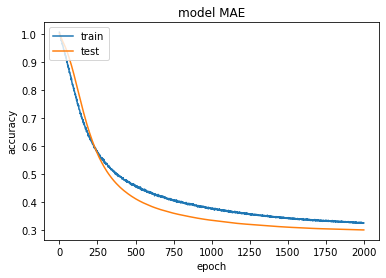

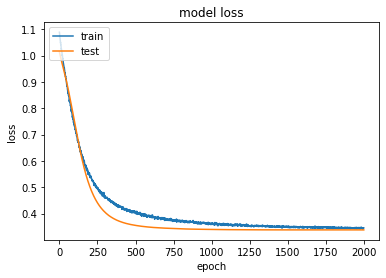

In [54]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
preds=model.predict(X_test)

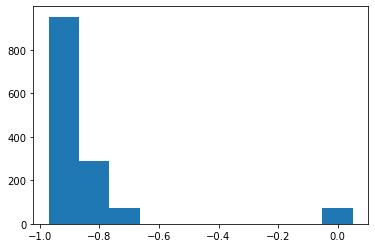

In [65]:
plt.hist(preds.ravel());

In [77]:
correct=0
for i, j in zip(preds.argsort(axis=1)[:,:2],y_test.argsort(axis=1)[:,:2]):
    for k in i:
        if k in j:
            correct+=1
print("top 2 test accuracy, since we are predicting two class labels",correct/(len(preds)*2))

top 2 test accuracy, since we are predicting two class labels 0.4452054794520548


In [80]:
manifest.head()

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,No Second Type
ix,,,,,,,,,,,,,,,,,,,,
0.0,luxio,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1.0,oshawott,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2.0,parasect,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3.0,taillow,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4.0,porygon,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


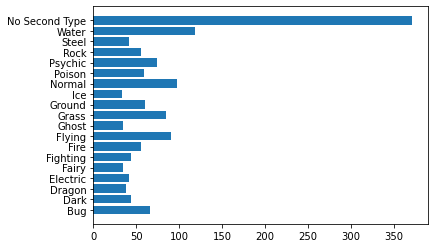

In [106]:
plt.barh(y=range(19),width=np.array(manifest.sum(axis=0))[1:],tick_label=manifest.columns[1:],orientation='horizontal');

Since the 'No Second type class' completely predominates, we shift the problem over to only predicting the primary type...

# Let's start over and predict only the first Type:

In [185]:
manifest=pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')
y=pd.get_dummies(manifest.Type1)
manifest=pd.concat([manifest['Name'].reset_index(drop=True), y], axis=1)
names=[]
index=0

for dirname, _, filenames in os.walk('/kaggle/input/pokemon-images-and-types/images/images/'):
    for filename in filenames:
        file_path_i = os.path.join(dirname, filename)
        name_i = filename.replace('.png','')
        names.append({'Name':name_i,'ix':index})
        if index==0:
            x=load_img(file_path_i)
            x=img_to_array(x)
            x.shape=(1,120,120,3)
            x=x/255.
        else:
            xi=load_img(file_path_i)
            xi=img_to_array(xi)
            xi.shape=(1,120,120,3)
            xi=xi/255.
            x = np.concatenate((x,xi),axis=0)
        index+=1
        #print(index)
names=pd.DataFrame(names)
manifest=manifest.merge(names,how='left')
dropme=np.where(manifest.ix.isna())
manifest.dropna(inplace=True)
manifest = manifest.set_index('ix',drop=True).sort_index()
x= np.delete(x,dropme,axis=0)
y=manifest.drop('Name',axis=1).values
x = np.float32(x)
X_train, X_test, y_train, y_test = train_test_split(
     x, y, test_size=0.15, random_state=42)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [187]:
X_test.shape,y_test.shape

((109, 120, 120, 3), (109, 18))

In [209]:
model = Sequential()
model.add(tf.keras.layers.GaussianNoise(stddev=0.2,input_shape=(x.shape[1],x.shape[2],x.shape[3])))
model.add(Conv2D(filters=256,kernel_size=(10,10),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=128,kernel_size=(8,8),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(6,6),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(4096,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(Dropout(rate=0.25))
model.add(Dense(4096,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(Dropout(rate=0.25))
model.add(Dense(4096,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=tf.keras.regularizers.l2(1e-6),
    activity_regularizer=tf.keras.regularizers.l2(1e-6)))
model.add(Dropout(rate=0.25))
model.add(Dense(y.shape[1],activation='softmax'))

adam=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True)

model.compile(optimizer=adam,
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(X_train,y_train,batch_size=8,epochs=100,validation_split=0.15,shuffle=True)

Epoch 1/100
65/65 [==============================] - 5s 79ms/step - loss: 10.2752 - mean_absolute_error: 0.1033 - val_loss: 10.0128 - val_mean_absolute_error: 0.1045
Epoch 2/100
65/65 [==============================] - 5s 71ms/step - loss: 9.6347 - mean_absolute_error: 0.1027 - val_loss: 9.4567 - val_mean_absolute_error: 0.1046
Epoch 3/100
65/65 [==============================] - 5s 74ms/step - loss: 9.0978 - mean_absolute_error: 0.1029 - val_loss: 8.9064 - val_mean_absolute_error: 0.1044
Epoch 4/100
65/65 [==============================] - 5s 72ms/step - loss: 8.5980 - mean_absolute_error: 0.1031 - val_loss: 8.4444 - val_mean_absolute_error: 0.1044
Epoch 5/100
65/65 [==============================] - 5s 72ms/step - loss: 8.1700 - mean_absolute_error: 0.1026 - val_loss: 8.0353 - val_mean_absolute_error: 0.1044
Epoch 6/100
65/65 [==============================] - 5s 71ms/step - loss: 7.7678 - mean_absolute_error: 0.1030 - val_loss: 7.6395 - val_mean_absolute_error: 0.1041
Epoch 7/100
65

Epoch 51/100
65/65 [==============================] - 5s 72ms/step - loss: 3.0396 - mean_absolute_error: 0.1007 - val_loss: 3.3685 - val_mean_absolute_error: 0.1029
Epoch 52/100
65/65 [==============================] - 5s 72ms/step - loss: 2.9956 - mean_absolute_error: 0.1000 - val_loss: 3.3442 - val_mean_absolute_error: 0.1031
Epoch 53/100
65/65 [==============================] - 5s 72ms/step - loss: 3.0041 - mean_absolute_error: 0.1005 - val_loss: 3.4173 - val_mean_absolute_error: 0.1030
Epoch 54/100
65/65 [==============================] - 5s 74ms/step - loss: 2.9518 - mean_absolute_error: 0.0999 - val_loss: 3.3989 - val_mean_absolute_error: 0.1024
Epoch 55/100
65/65 [==============================] - 5s 73ms/step - loss: 2.9290 - mean_absolute_error: 0.0994 - val_loss: 3.3390 - val_mean_absolute_error: 0.1027
Epoch 56/100
65/65 [==============================] - 5s 72ms/step - loss: 2.8815 - mean_absolute_error: 0.0989 - val_loss: 3.4692 - val_mean_absolute_error: 0.1028
Epoch 57/1

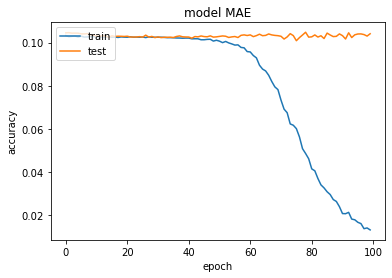

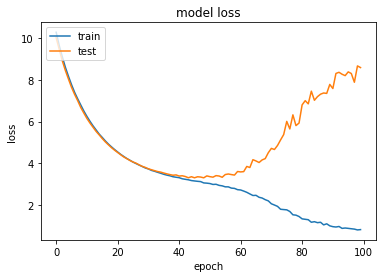

In [210]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [220]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input
model = VGG16(include_top=False)
new_input = Input(shape=(x.shape[1],x.shape[2],x.shape[3]))
model = VGG16(weights=None, input_tensor=new_input, classes=y.shape[1])

In [221]:
x = preprocess_input(x)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(
     x, y, test_size=0.15, random_state=42)

In [223]:
adam=tf.keras.optimizers.Adam(
    learning_rate=0.0000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True)
model.compile(optimizer=adam,
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(X_train,y_train,batch_size=8,epochs=100,validation_split=0.15,shuffle=True)

Epoch 1/100
65/65 [==============================] - 3s 41ms/step - loss: 2.9491 - mean_absolute_error: 0.1051 - val_loss: 2.9043 - val_mean_absolute_error: 0.1049
Epoch 2/100
65/65 [==============================] - 3s 39ms/step - loss: 2.8900 - mean_absolute_error: 0.1048 - val_loss: 2.8581 - val_mean_absolute_error: 0.1046
Epoch 3/100
65/65 [==============================] - 2s 38ms/step - loss: 2.8475 - mean_absolute_error: 0.1045 - val_loss: 2.8249 - val_mean_absolute_error: 0.1044
Epoch 4/100
65/65 [==============================] - 2s 38ms/step - loss: 2.8162 - mean_absolute_error: 0.1043 - val_loss: 2.7977 - val_mean_absolute_error: 0.1041
Epoch 5/100
65/65 [==============================] - 2s 38ms/step - loss: 2.7909 - mean_absolute_error: 0.1040 - val_loss: 2.7796 - val_mean_absolute_error: 0.1039
Epoch 6/100
65/65 [==============================] - 3s 39ms/step - loss: 2.7722 - mean_absolute_error: 0.1038 - val_loss: 2.7638 - val_mean_absolute_error: 0.1037
Epoch 7/100
65/6

Epoch 51/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6977 - mean_absolute_error: 0.1025 - val_loss: 2.7410 - val_mean_absolute_error: 0.1025
Epoch 52/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6985 - mean_absolute_error: 0.1025 - val_loss: 2.7414 - val_mean_absolute_error: 0.1026
Epoch 53/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6977 - mean_absolute_error: 0.1025 - val_loss: 2.7401 - val_mean_absolute_error: 0.1025
Epoch 54/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6977 - mean_absolute_error: 0.1024 - val_loss: 2.7391 - val_mean_absolute_error: 0.1025
Epoch 55/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6982 - mean_absolute_error: 0.1025 - val_loss: 2.7414 - val_mean_absolute_error: 0.1025
Epoch 56/100
65/65 [==============================] - 2s 38ms/step - loss: 2.6976 - mean_absolute_error: 0.1024 - val_loss: 2.7417 - val_mean_absolute_error: 0.1025
Epoch 57/1

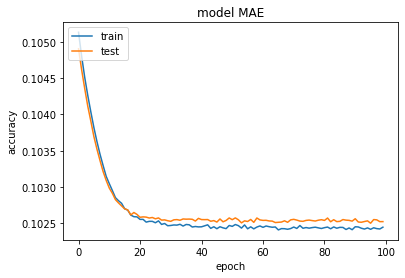

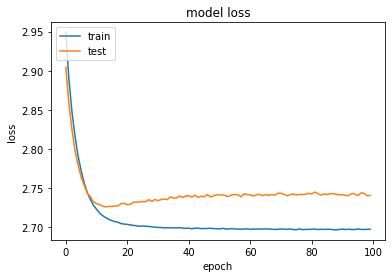

In [224]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [231]:
preds=model.predict(X_test)

In [232]:
preds.shape,y_test.shape

((109, 18), (109, 18))

In [236]:
len(np.where(np.argmax(preds,axis=1)==np.argmax(y_test,axis=1)))/y_test.shape[0]

0.009174311926605505

In [237]:
preds=model.predict(X_train)

In [238]:
len(np.where(np.argmax(preds,axis=1)==np.argmax(y_train,axis=1)))/y_train.shape[0]

0.0016339869281045752

In [239]:
x.shape

(721, 120, 120, 3)

# Conclusion

There are simply not enough training observations in this dataset to be able to predict Pokemon classes with, most deep learning set-ups require thousands, if not millions of observations to train on